In [1]:
import sys
# sys.path.append(r'/zhome/60/1/118435/Master_Thesis/GoalCornerDetection')
sys.path.append(r'C:\\Users\\Nikolaj\\OneDrive - Danmarks Tekniske Universitet\\DTU\\Kandidat\\MasterThesis\\Code\\GoalCornerDetection')
!nvidia-smi

Thu Jan 12 15:46:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8     4W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from Core.DataLoader import GoalCalibrationDataset,GoalCalibrationDataset4boxes,GoalCalibrationDatasetOLD,\
train_transform,make_gt_boxes
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from utils import DATA_DIR
import matplotlib.pyplot as plt
from Core.helpers import to_numpy,im_to_numpy,split_data_train_test,test_num_workers, \
find_pixelerror,eval_PCK, PCK_auc, MSE_loss_corners
import numpy as np
import cv2
import json
from Core.plottools import target_to_keypoints, visualize_results, visualize, get_prediction_images, \
crop_image, crop_images, filter_preds, kps_to_cv2, make_pred_image, visualize_cropped_results, visualize_images
import torchvision
from PIL import Image
import albumentations as A # Library for augmentations
import torchvision.transforms as T
from tqdm.notebook import tqdm
from torch.utils.data import random_split,Subset,DataLoader,RandomSampler
from Core.torchhelpers.utils import collate_fn
import pandas as pd
from pprint import pprint
from torchinfo import summary
from torch.utils.data import DataLoader
from Core.torchhelpers.utils import collate_fn
import time
import datetime
from Models.modelzoo import load_custom_batch,loadmymodel
import pickle

In [3]:
## Load datasets
GoalDataold = GoalCalibrationDatasetOLD(DATA_DIR)
GoalData = GoalCalibrationDataset(DATA_DIR)
GoalData4box = GoalCalibrationDataset4boxes(DATA_DIR)

All images: 854
Filtered images: 754
All images: 854
Filtered images: 754
All images: 854
Filtered images: 754
Config not given, using default values for bbox_expand.


In [4]:
train_loader,validation_loader = split_data_train_test(GoalData,
                                                       GoalData,
                                                       validation_split=0.25,
                                                       batch_size=4,
                                                       data_amount=1,
                                                       num_workers=2,
                                                       shuffle_dataset=True,
                                                       shuffle_dataset_seed=20,
                                                       shuffle_epoch = False,
                                                       shuffle_epoch_seed=-1,
                                                       pin_memory=False)

###################
Total size of dataset: 754
Train data --> Size: 566, batch size: 4
Validation data --> Size: 188, batch size: 4


# plot bboxes in 1box method

In [5]:
images,targets = next(iter(train_loader))

In [14]:
images_gt = [make_pred_image(image,
                 bboxes=target['boxes'],
                 keypointsGT=target['keypoints'],
                 opaqueness=1)
            for image,target in zip(images,targets)]

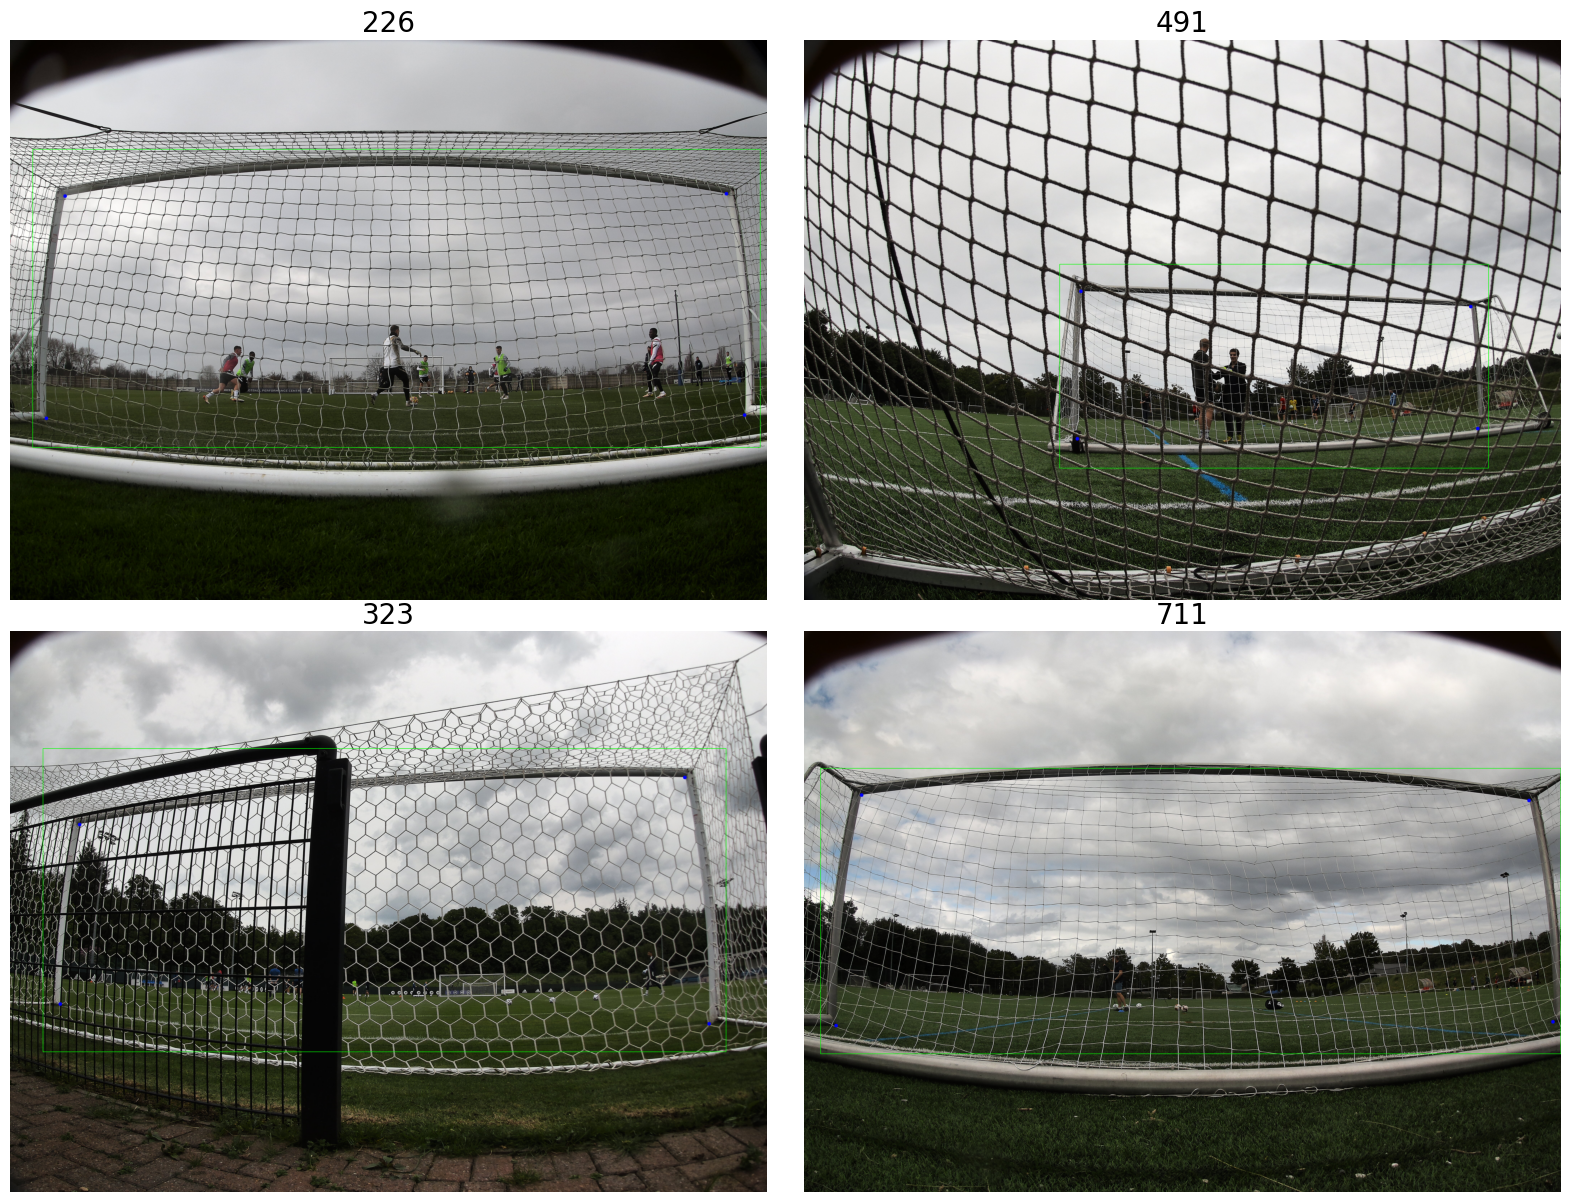

In [15]:
# images_np = [im_to_numpy(image) for image in images_gt]
visualize_images(images_gt,
                 figtitle=None,
                 subplottitles=[t['image_id'].item() for t in targets],
                 figsize=(20, 15),
                 show_axis=False,
                 subplottitlesize=20)